In [2]:
import numpy as np
from matplotlib import pyplot
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
from IPython import display
import urllib
#!pip install scipy (uncomment if error is given saying no module named 'scipy' is given)
from scipy import integrate
from IPython.core.display import display, HTML
%matplotlib inline

#use LaTeX in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Source Panel Method
Conceptually, we break up the geometry into small linear segments (**panels**), where each has a constant singularity strength. We then must apply several boundary conditions:
1. No-flow-through: No fluid flows through the airfoil
2. Kutta Condition: The streamline at the trailing edge must be smooth and not infinite.
3. Neumann Boundary Condition: $\frac{\partial \phi}{\partial n} = 0$

Let's analyze a NACA 0012 airfoil, which is symmetric. First, we import the airfoil's coordinates using the Selig format from airfoiltools.com (starts at the trailing edge, then goes to the leading edge over the upper surface and returns back to the trailing edge over the lower half). 

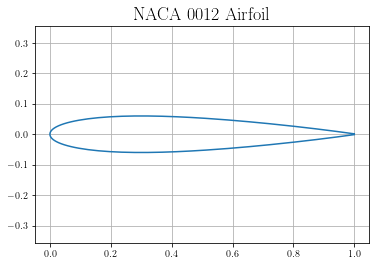

In [3]:
#Obtain the selig data url from airfoiltols.com, paste the link, and save it to a file
selig_link = 'http://airfoiltools.com/airfoil/seligdatfile?airfoil=n0012-il'
selig_data = 'naca0012-selig.dat'
urllib.request.urlretrieve(selig_link, selig_data)

#load the coordinates and store it
with open(selig_data, 'r') as infile:
    x, y = np.loadtxt(infile, unpack=True, skiprows=1)

#draw the airfoil    
plt.grid(True)
plt.title(r'NACA 0012 Airfoil', fontsize=18)
plt.plot(x,y)
plt.axis('equal');

In [4]:
class PanelGeometry:
    """
    Calculates the geometrical information of a given panel
    """
    def __init__(self, xk, yk, xkp1, ykp1):
        """
        Input Parameters:
        - xk is the x coordinate of the k-th element
        - xkp1 is the x coordinate of the (k+1)-th element
        - yk is the y coordinate of the k-th element
        - ykp1 is the y coordinate of the (k+1)-th element
        """
        self.xk = xk
        self.yk = yk
        self.xkp1 = xkp1
        self.ykp1 = ykp1
        self.L = 0
        self.x_ctrl = 0
        self.y_ctrl = 0
        self.α = 0
        self.n = 0
        
    def length(self, xk, yk, xkp1, ykp1):
        """
        Input Parameters:
        - xk is the x coordinate of the k-th element
        - xkp1 is the x coordinate of the (k+1)-th element
        - yk is the y coordinate of the k-th element
        - ykp1 is the y coordinate of the (k+1)-th element
        
        Output Parameters:
        - L is the length of the panel
        """
        L = np.sqrt((self.xk - self.xkp1)**2 + (self.yk - self.ykp1)**2)
        
        self.L = L
        return L
    
    def controlPoint(self, xk, yk, xkp1, ykp1):
        """
        Input Parameters:
        - xk is the x coordinate of the k-th element
        - xkp1 is the x coordinate of the (k+1)-th element
        - yk is the y coordinate of the k-th element
        - ykp1 is the y coordinate of the (k+1)-th element
        
        Output Parameters:
        - x_ctrl is the x coordinate of the control point (center of the panel)
        - y_ctrl is the y coordinate of the control point (center of the panel)
        """
        x_ctrl = (self.xk + self.xkp1) / 2
        y_ctrl = (self.yk + self.ykp1) / 2
        
        self.x_ctrl = x_ctrl
        self.y_ctrl = y_ctrl
        return x_ctrl, y_ctrl
    
    def angle(self, xk, yk, xkp1, ykp1):
        """
        Input Parameters:
        - xk is the x coordinate of the k-th element
        - xkp1 is the x coordinate of the (k+1)-th element
        - yk is the y coordinate of the k-th element
        - ykp1 is the y coordinate of the (k+1)-th element
        
        Output Parameters:
        - ϕ is the angle of the panel w.r.t. the x axis
        - α is the angle of the normal w.r.t. the x axis 
        """
        x_length = self.xk - self.xkp1
        y_length = self.yk - self.ykp1
        
        if x_length > 0.:
            #on the upper half of the airfoil
            ϕ = np.arctan2(y_length, x_length)
            α = ϕ + math.pi/2
        else:
            ϕ = np.arctan2(y_length, x_length) #add 2π to the panel angle
            α = ϕ + math.pi/2
            
        self.ϕ = ϕ
        self.α = α
        return ϕ, α

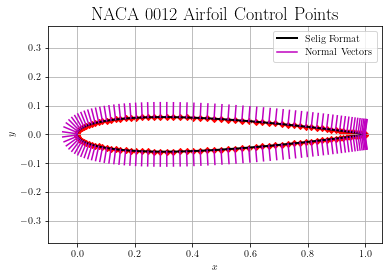

In [5]:
numPan = len(x) - 1          #number of panels
α = 0                        #angle of attack in radians
θ = np.zeros(numPan)         #array to store angle of panels w.r.t horizontal axis
L = np.zeros(numPan)         #array to store length of each panel
x_control = np.zeros(numPan) #array to store x control points
y_control = np.zeros(numPan) #array to store y control points
panel_objects = []           #list to store the objects (and its corresponding attributes) for each panel

#create an object for each panel
for k in range(numPan):
    panel_objects.append(PanelGeometry(x[k], y[k], x[k+1], y[k+1]))

k = 0

#assign each panel object with the length, control point, and angles
for obj in panel_objects:
    obj.length(x[k], y[k], x[k+1], y[k+1])
    obj.controlPoint(x[k], y[k], x[k+1], y[k+1])
    obj.angle(x[k], y[k], x[k+1], y[k+1])
    k += 1

#print(panel_objects[2].length(x[2], y[2], x[3], y[3]))  #returns expected value  
#plot the data
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'NACA 0012 Airfoil Control Points', fontsize=18)
plt.plot(x,y,color='k', linestyle='-', linewidth=2)
for k in range(numPan):
    plt.scatter(panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[0], panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[1], color='r', s=18, marker='D') #plot the control points
    plt.plot([panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[0], panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[0] + 0.05 * np.cos(panel_objects[k].angle(x[k], y[k], x[k+1], y[k+1])[1])], \
[panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[1], panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[1] + 0.05 * np.sin(panel_objects[k].angle(x[k], y[k], x[k+1], y[k+1])[1])], color='m')
plt.legend([r'Selig Format', r'Normal Vectors'])
plt.axis('equal');

In [6]:
class FreeStream:
    """
    Generates conditions of the freestream
    """
    def __init__(self, U_infty, θ):
        """
        Input Parameters:
        - U_infty is the velocity of the freestream in [m/s]
        - θ is the angle of the freestream w.r.t. to the x axis
        """
        self.U_infty = U_infty
        self.θ = θ

In [7]:
U_infty = 1.0                     #speed of the freestream in [m/s]
θ = 0                             #angle of the free stream w.r.t. x axis
fs = FreeStream(U_infty, θ)       #create an object by calling the FreeStream class

Now, let's build the theoretical framework for the source panel method. We place singularities on each panel, where each panel of strength $\lambda ds$ generates a potential $d\phi$:
$$d\phi = \frac{\lambda ds}{2\pi}\ln r $$
The no-flow-through boundary condition must be imposed, which is satisfied by placing these singularities on the surface. So,
$$U_{\infty,N} + U_N = 0$$
A linear algebra equation can be formulated, which is easily solved in Python.
$$\frac{\lambda_i}{2} + U_\infty \cos\alpha_i + \sum_{j = 1 \\ (j \neq i)}^{N}\frac{\lambda_j}{2\pi}\int_{j}\frac{\partial}{\partial n_i}(\ln r_{ij})ds_j = 0 $$
where $\dfrac{\partial}{\partial n_i}(\ln r_{ij}) = \frac{(x_{c_i} - x_j)\cos\alpha_i + (y_{c_i} - y_j)\sin\alpha_i}{(x_{c_i} - x_j)^2 + (y_{c_i} - y_j)^2}$. It is important to make the distinction that $\alpha$ is NOT the freestream angle/angle of attack ($\theta$ is the angle of attack). Note that we can evaluate the integral and this equation becomes a linear equation, where the strengths $\lambda_i$ can be obtained.
Thus, the component of the freestream velocity tangential to the surface is
$$U_{T,i} = U_\infty \sin\alpha_i $$
The normal component of the velocity at the $i$th control point is
$$U_{N,i} = \frac{\partial}{\partial n_i}\left[\phi(x_i, y_i)\right] = U_\infty \cos\alpha_i$$
Ultimately, the sum of all the singularities on the airfoil body must equate to 0 or the body would be absorbing/leaking mass. Mathematically, this is expressed by
$$\sum_{j = 1}^{N}\lambda_j S_j = 0 $$
where $\lambda_j$ is the strength of the $j$th panel and $S_j$ is the length of panel. We also need a variable of intergration ($s_j$ since we are performing $ds_j$ in the integral), so
$$x_j = X_j + s_j\cos\phi_j = X_j + s_j\sin\alpha_j$$
$$y_j = Y_j + s_j\sin\phi_j = Y_j - s_j\cos\alpha_j$$
where $X_j$ and $Y_j$ are the start points of the $j$-th panel and $\phi_j$ are the angles measured counterclockwise from the $x$ axis to the panel. Thus, the panel geometry integral equation that can be implemented becomes
$$\frac{\lambda_i}{2} + U_\infty \cos\alpha_i + \sum_{j = 1 \\ (j \neq i)}^{N}\frac{\lambda_j}{2\pi}\int_{j}\frac{\left(x_{c_i} - X_j + s_j\sin\alpha_j\right)\cos\alpha_i + \left(y_{c_i} - Y_j - s_j\cos\alpha_j \right)\sin\alpha_i}{\left(x_{c_i} - X_j + s_j\sin\alpha_j\right)^2 +\left(y_{c_i} - Y_j - s_j\cos\alpha_j \right)^2 }ds_j = 0$$

In [8]:
def calc_integral(xc, yc, Xj, Yj, αi, αj, L):
    """
    Input Parameters:
    - xc is the i-th panel's x control point
    - yc is the i-th panel's y control point
    - Xj is the j-th panel's x start point
    - Yj is the j-th panel's y start point 
    - αi is the angle of the i-th panel
    - αj is the angle of the j-th panel
    - L is the length of the j-th control panel
    - Note that all of the above parameters are obtained from the panel_objects list
    
    Output Parameters:
    - I_ij is the value of the integral
    """
    #Define the integrand
    integrand = lambda sj: ((xc - Xj + sj*np.sin(αj))*np.cos(αi) + (yc - Yj - sj*np.cos(αj))*np.sin(αi)) / ((xc - Xj + sj*np.sin(αj))**2 + (yc - Yj - sj*np.cos(αj))**2)
    
    #Use scipy to obtain the integral
    I_ij = integrate.quad(integrand, 0.0, L)[0]
    return I_ij

In [9]:
#Evaluate the integral for each cell
I_ij = np.zeros((numPan, numPan))

for i in range(numPan):
    xc = panel_objects[i].controlPoint(x[i], y[i], x[i+1], y[i+1])[0]
    yc = panel_objects[i].controlPoint(x[i], y[i], x[i+1], y[i+1])[1]
    αi = panel_objects[i].angle(x[i], y[i], x[i+1], y[i+1])[1]
    for j in range(numPan):
        if i != j:
            Xj = x[j]
            Yj = y[j]
            αj = panel_objects[j].angle(x[j], y[j], x[j+1], y[j+1])[1]
            L = panel_objects[j].length(x[j], y[j], x[j+1], y[j+1])
            I_ij[i][j] = calc_integral(xc, yc, Xj, Yj, αi, αj, L)


From here, this can be written in matrix form:
$$\underbrace{\begin{bmatrix}
\frac{1}{2} & \frac{1}{2\pi}I_{1,2} & \dots & \frac{1}{2\pi}I_{1,N} \\
\frac{1}{2\pi}I_{2,1} & \frac{1}{2} & \dots & \frac{1}{2\pi}I_{2,N} \\
\vdots & & \ddots & \vdots \\
\frac{1}{2\pi}I_{N,1} & \frac{1}{2\pi}I_{N,2} & \dots & \frac{1}{2}
\end{bmatrix}}_{A}
\underbrace{\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_N
\end{bmatrix}}_{\lambda}
= \underbrace{\begin{bmatrix}
-U_\infty\cos\alpha_{i=1} \\
-U_\infty\cos\alpha_{i=2} \\
\vdots \\
-U_\infty\cos\alpha_{i=N}
\end{bmatrix}}_{B} $$
where $A$ is a `numPan` $\times$ `numPan` matrix and $\lambda$ and $B$ are matrices of dimension `numPan` $\times 1$.The solution to this equation is $\lambda = A^{-1}B$

In [10]:
#Function to populate the A matrix
def A_Matrix(I_ij, numPan, panel_objects):
    """
    Input Parameters:
    - I_ij is the numPan x numPan array that stores the values of the integral
    - numPan is the number of panels
    - panel_objects is the list of PanelGeometry objects for each panel
    
    Output Parameters:
    - A is the A matrix seen in the linear equation above and is a numPan x numPan np.array
    """
    A = np.zeros((numPan, numPan))
    np.fill_diagonal(A, 0.5)
    
    for i in range(numPan):
        for j in range(numPan):
            if i != j:
                A[i][j] = 1 / (2 * math.pi) * I_ij[i][j]
        
    return A

In [11]:
def B_Matrix(panel_objects, freestream, numPan):
    """
    Input Parameters:
    - panel_objects is the list of PanelGeometry objects for each panel
    - freestream is the freeStream object that contains the characteristics of the freestream.
    - numPan is the number of panels
    
    Output Parameters:
    - B is the B matrix seen in the linear equation above and is a numPan x 1 np.array type
    """
    B = np.zeros(numPan)
    
    for i, panelCount in enumerate(panel_objects):
        B[i] = -freestream.U_infty * np.cos(freestream.θ - panelCount.α)   
    return B

In [12]:
#Populate the A and B matrices by calling the defined functions above
A = A_Matrix(I_ij, numPan, panel_objects)
B = B_Matrix(panel_objects, fs, numPan)

#Solve the linear algebra system

λ = np.linalg.solve(A, B)

Let's check if the obtained system is correct by performing
$$\sum_{j = 1}^{N}\lambda_j S_j = 0$$

In [13]:
#Check if the sum above adds up to 0
zerocheck = np.zeros(numPan)

for k, panel in enumerate(panel_objects):
    zerocheck[k] = panel.length(x[k], y[k], x[k+1], y[k+1]) * λ[k]
    
sum = np.sum(zerocheck)
print('Sum of all Sources/Sinks: {}'.format(sum))
#Note that as you increase the freestream speed, the sum increases too (unsure if this is a bug or a flaw with the method)

Sum of all Sources/Sinks: 0.003426567054006273


# Pressure Coefficient Using Bernoulli's Equation
On the $i$-th panel, the pressure coefficient is defined by
$$C_{p_i} = 1 - \left(\frac{u_{t_i}}{U_\infty}\right)^2 $$
where $u_{t_i}$ is the tangential velocity at the $i$-th panel's control point. $u_{t_i}$ is defined as
$$u_{t_i} = U_{\infty,s} + u_s$$
where
$$U_{\infty,s} = U_\infty\sin\alpha_i, \quad u_s = \frac{\partial\phi}{\partial s} = \sum_{j = 1 \\ {(j \neq i)}}^{N}\frac{\lambda_j}{2\pi}\int_{j}\frac{\partial}{\partial s}\left(\ln r_{ij} \right)ds_j$$
Equivalently, we can transform this to a form that we can implement into the code:
$$u_{t_i} = U_\infty\sin\alpha_i + \sum_{j = 1 \\ (j \neq i)}^{N}\frac{\lambda_j}{2\pi}\int_j\frac{-\left(x_{c_i} - X_j + s_j\sin\alpha_j \right)\sin\alpha_i + \left(y_{c_i} - Y_j - \cos\alpha_j \right)\cos\alpha_i}{\left(x_{c_i} - X_j + s_j\sin\alpha_j \right)^2 + \left(y_{c_i} - Y_j - \cos\alpha_j \right)^2}ds_j $$

In [15]:
#function calculate tangential integral
def calc_tang_integral(xc, yc, Xj, Yj, αi, αj, L):
    """
    Input Parameters:
    - xc is the i-th panel's x control point
    - yc is the i-th panel's y control point
    - Xj is the j-th panel's x start point
    - Yj is the j-th panel's y start point 
    - αi is the angle of the i-th panel
    - αj is the angle of the j-th panel
    - L is the length of the j-th control panel
    - Note that all of the above parameters are obtained from the panel_objects list
    
    Output Parameters:
    - I_ij is the value of the integral
    """
    #Define the integrand
    integrand = lambda sj: ((xc - Xj + sj*np.sin(αj))*-np.sin(αi) + (yc - Yj - sj*np.cos(αj))*np.cos(αi))/ \
    ((xc - Xj + sj*np.sin(αj))**2 + (yc - Yj - sj*np.cos(αj))**2)
    
    #Use scipy to obtain the integral
    I_ij = integrate.quad(integrand, 0.0, L)[0]
    
    return I_ij

In [16]:
#Function to obtain the tangential velocity
def calc_tang_velocity(panel_objects, fs, numPan, λ, x, y):
    """
    Input Parameters:
    - panel_objects is the list of panelGeometry objects
    - fs is the freeStream object
    - numPan is the number of panels
    - λ is the array of the strengths of each panel
    - x is the array that stores the x coordinates of the airfoil
    - y is the array that stores the y coordinates of the airfoil
    
    Output Parameters:
    - u_ti is the tangential velocity component for the i-th panel
    """
    u_ti = np.zeros((numPan))
    A_t = np.zeros((numPan, numPan))
    np.fill_diagonal(A, 0.)
    
    for i, panelCount_i in enumerate(panel_objects):
        xc = panelCount_i.controlPoint(x[i], y[i], x[i+1], y[i+1])[0]
        yc = panelCount_i.controlPoint(x[i], y[i], x[i+1], y[i+1])[1]
        αi = panelCount_i.angle(x[i], y[i], x[i+1], y[i+1])[1]
        for j, panelCount_j in enumerate(panel_objects):
            Xj = x[j]
            Yj = y[j]
            αj = panelCount_j.angle(x[j], y[j], x[j+1], y[j+1])[1]
            L = panelCount_j.length(x[j], y[j], x[j+1], y[j+1])
            if i != j:
                A_t[i][j] = 1 / (2 * math.pi) * calc_tang_integral(xc, yc, Xj, Yj, αi, αj, L)
    
    B = fs.U_infty * np.sin([fs.θ - panel.α for panel in panel_objects])
    
    u_ti = np.dot(A_t, λ) + B
    
    return u_ti

In [17]:
def Cp(u_ti, fs, numPan):
    """
    Input Parameters:
    - u_ti is the array that stores the tangential velocities of each panel
    - fs is the FreeStream object
    
    Output Parameters:
    - Cp is an array that stores the pressure coefficient
    """
    Cp = np.zeros(numPan)
    
    for i in range(numPan):
        Cp[i] = 1.0 - (u_ti[i] / fs.U_infty)**2
    
    return Cp

In [18]:
#Theoretical solution obtained from a NACA Report No. 824 (Summary of Airfoil Data)
Cp_theoretical = np.array([1.0, 0.36, -0.01, -0.241, -0.378, -0.402, -0.411, -0.411, -0.399, -0.378, -0.350, -0.288, -0.228, -0.166, -0.109, -0.044, 0.044, 0.094, 1])
x_percent_c = np.array([0., 0.005, 0.0125, 0.025, 0.050, 0.075, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 1.0])
Cp_i = np.zeros(numPan)
u_ti = np.zeros(numPan)

#Call the functions
u_ti = calc_tang_velocity(panel_objects, fs, numPan, λ, x, y)
Cp_i = Cp(u_ti, fs, numPan)
ind = int(numPan/2)

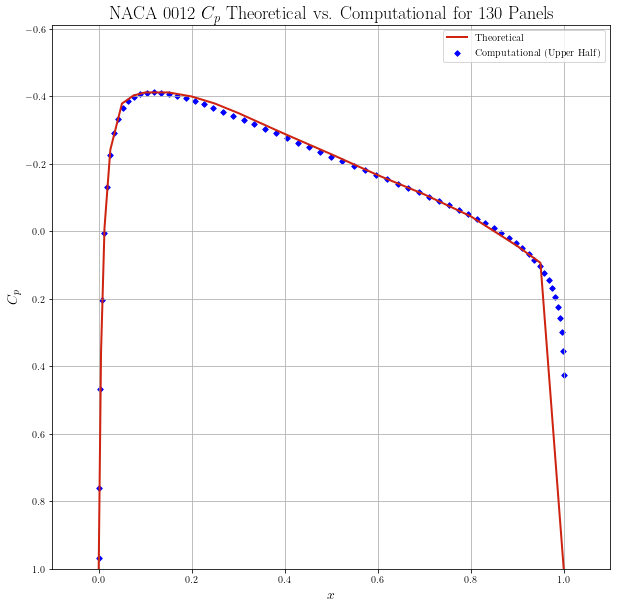

In [19]:
#Plot the data
L = 10
H = 10
plt.figure(figsize=(L,H))
plt.xlim(0-0.1, 1+0.1)
plt.ylim(1.0, np.min(Cp_theoretical)-0.2)
plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$C_p$',fontsize=14)
plt.title(r'NACA 0012 $C_p$ Theoretical vs. Computational for {} Panels'.format(numPan), fontsize=18)
plt.grid(True)
plt.plot(x_percent_c, Cp_theoretical, color='#CD2310', linewidth=2)
for k in range(ind):
    plt.scatter(panel_objects[k].controlPoint(x[k], y[k], x[k+1], y[k+1])[0], Cp_i[k], color = 'b', s=15, marker='D')
plt.legend([r'Theoretical', r'Computational (Upper Half)']);

This result is aligned with the theoretical result verywhere except at the trailing edge: since we are calculating the pressure coefficient at the control point, there will be a slight disconnect between the theoretical and computational result, where the theoretical result utilizes Theordorsen's method at the trailing edge. Also, one observation: the trailing edge and leading edge are where the maximum of the plot occurs, where $C_p = 0$, which is indicative of stagnation points since $u_{t_i} = 0$. Since the source panel method is for non-lifting bodies, the upper and lower surfaces have the same $C_p$ distribution.

# Velocity Field and Contour Plot
The velocity components are represented by
$$u(x,y) = \frac{\partial\phi}{\partial x}$$
$$v(x,y) = \frac{\partial\phi}{\partial y}$$

In [20]:
#integral for velocity field
def vel_integral(xc, yc, Xj, Yj, αj, L, x_arg, y_arg):
    """
    Input Parameters:
    - xc is the x_grid point
    - yc is the y_grid point
    - Xj is the j-th panel's x start point
    - Yj is the j-th panel's y start point 
    - αi is the angle of the i-th panel
    - αj is the angle of the j-th panel
    - L is the length of the j-th control panel
    - x_arg is the x argument that is multiplied by the x variables in the numerator
    - y_arg is the y argument that is multiplied by the y variables in the denominator
    - Note that all of the above parameters are obtained from the panel_objects list
    
    Output Parameters:
    - I_ij is the value of the integral
    """
    #Define the integrand
    integrand = lambda sj: ((xc - Xj + sj*np.sin(αj))*(x_arg) + (yc - Yj - sj*np.cos(αj))*y_arg)/ \
    ((xc - Xj + sj*np.sin(αj))**2 + (yc - Yj - sj*np.cos(αj))**2)
    
    #Use scipy to obtain the integral
    I_ij = integrate.quad(integrand, 0.0, L)[0]
    
    return I_ij

In [21]:
#Function to calculate the velocity field
def velocity_field(panel_objects, fs, λ, x_grid, y_grid, N_pts, x, y):
    """
    Input Parameters:
    - panel_objects is the list of PanelGeometry objects for each panel
    - freestream is the freeStream object that contains the characteristics of the freestream.
    - λ is an array that stores the source/sink strength of each panel
    - x_grid is the array of x values on the meshgrid
    - y_grid is the array of y values on the meshgrid
    - N_pts is the number of pts
    
    Output Parameters:
    - u is the array of the u component of velocity 
    - v is the array of the v component of velocity
    """
    u = np.zeros((N_pts, N_pts))
    v = np.zeros((N_pts, N_pts))

    #for i in range(numPan):
     #   xc = panel_objects[i].controlPoint(x[i], y[i], x[i+1], y[i+1])[0]
      #  yc = panel_objects[i].controlPoint(x[i], y[i], x[i+1], y[i+1])[1]
       # αi = panel_objects[i].angle(x[i], y[i], x[i+1], y[i+1])[1]
        #for j in range(numPan):
         #   #Velocity contribution from the freestream
          #  u[i][j] = fs.U_infty * np.cos(fs.θ)
           # v[i][j] = fs.U_infty * np.sin(fs.θ)
            #Xj = x[j]
            #Yj = y[j]
            #αj = panel_objects[j].angle(x[j], y[j], x[j+1], y[j+1])[1]
            #L = panel_objects[j].length(x[j], y[j], x[j+1], y[j+1])
            #for k, panel in enumerate(panel_objects):
             #   #Apply the principle of superposition
              #  x_arg, y_arg = 1.0, 0.
               # x_arg2, y_arg2 = 0., 1.0
                #u[i][j] += λ[k] / (2 * math.pi) * vel_integral(xc, yc, Xj, Yj, αj, L, x_arg, y_arg)
                #v[i][j] += λ[k] / (2 * math.pi) * vel_integral(xc, yc, Xj, Yj, αj, L, x_arg2, y_arg2)
            
    #The method above takes a really long time to run and generates a lot of warnings
    #to address this, we use np.vectorize
    u = np.ones((N_pts, N_pts), dtype=float) * fs.U_infty * np.cos(fs.θ)
    v = np.ones((N_pts, N_pts), dtype=float) * fs.U_infty * np.sin(fs.θ)
    #integral_vals = np.vectorize(vel_integral)
    
    x_arg, y_arg = 1.0, 0. 
    x_arg2, y_arg2 = 0., 1.0
    
    for i in range(N_pts):
        for j in range(N_pts):
            xc = x_grid[i][j]
            yc = y_grid[i][j]
            αj = panel_objects[j].angle(x[j], y[j], x[j+1], y[j+1])[1]
            L = panel_objects[j].length(x[j], y[j], x[j+1], y[j+1])
            for k in range(numPan):
                Xj = x[k]
                Yj = y[k]
                #integral_u = 
                #integral_v = 
                u[i][j] += λ[k] / (2.0 * math.pi) * vel_integral(xc, yc, Xj, Yj, αj, L, x_arg, y_arg)
                v[i][j] += λ[k] / (2.0 * math.pi) * vel_integral(xc, yc, Xj, Yj, αj, L, x_arg2, y_arg2)

    return u, v

In [22]:
#Create meshgrid
N_pts = 40
x_left, x_right = -1.0, 2.0                      #x limit boundaries
y_bottom, y_top = -0.4, 0.4                      #y limit boundaries
X_pts = np.linspace(x_left, x_right, N_pts)      #points along the grid in the x direction
Y_pts = np.linspace(y_bottom, y_top, N_pts)      #points along the grid in the y direction
x_grid, y_grid = np.meshgrid(X_pts, Y_pts)       #create the grid

In [23]:
#Call the velocity_field function to obtain the velocity field
#This takes a few minutes to run... need to improve runtime... any ideas?
u_airfoil, v_airfoil = velocity_field(panel_objects, fs, λ, x_grid, y_grid, N_pts, x, y)

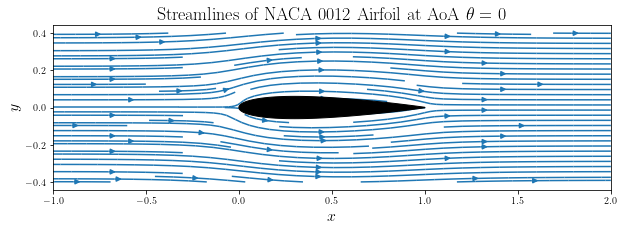

In [24]:
#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
plt.title(r'Streamlines of NACA 0012 Airfoil at AoA $\theta =$ {}'.format(fs.θ), fontsize=18)
plt.xlim(x_left, x_right)
plt.ylim(y_bottom, y_top)
plt.streamplot(x_grid, y_grid, u_airfoil, v_airfoil, arrowsize=1., linewidth=1.5, density=1)
plt.fill(x, y, color='k', zorder=2) #zorder=2 removes the streamlines inside the airfoil
plt.axis('scaled');

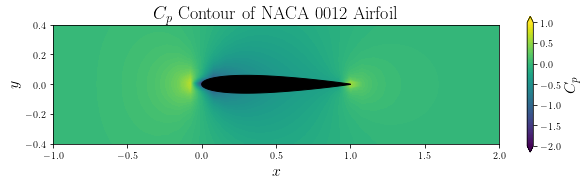

In [25]:
#Contour plot
Cp_contour = 1.0 - (u_airfoil**2 + v_airfoil**2) / (fs.U_infty)**2

#plot the data
plt.figure(figsize=(L,H))
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
plt.title(r'$C_p$ Contour of NACA 0012 Airfoil', fontsize=18)
plt.xlim(x_left, x_right)
plt.ylim(y_bottom, y_top)
contour_level = np.linspace(-2.0, 1.0, 100)
colorcont = plt.contourf(x_grid, y_grid, Cp_contour, levels=contour_level, extend='both')
colorbar = plt.colorbar(colorcont, shrink=0.25)
colorbar.set_ticks([-2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0])
colorbar.ax.set_ylabel(r'$C_p$', fontsize=16)
plt.axis('scaled')
plt.fill(x, y, color='k', zorder=2); #zorder=2 removes the streamlines inside the airfoil

# Lift and the Kutta-Joukowski Theorem
Obviously, as the number of singularities increases, the approximation becomes increasingly accurate. By the Kutta-Joukowski theorem, the lift per unit span about any closed, 2D body is
$$L' = \rho_\infty U_\infty \Gamma $$
where $\rho_\infty$ and $U_\infty$ are the density and velocity of the freestream, respectively. But, the source panel method works for **non-lifting** flow and the NACA 0012 airfoil is symmetric; to address this, the vortex panel method should be used for asymmetric airfoils so that lift can be generated.

In [ ]:
#Function to calculate lift

# References
1) <a href="http://airfoiltools.com/">Airfoil Tools</a> 

2) Barba, Lorena A., Mesnard, Olivier (2019). Aero Python: classical aerodynamics of potential flow using Python. Journal of Open Source Education, 2(15), 45, https://doi.org/10.21105/jose.00045

3) Ira Herbert Abbott, Albert Edward Von Doenhoff and Louis S. Stivers, Jr. (1945), "Summary of Airfoil Data," NACA Report No.824, <a href="https://ntrs.nasa.gov/citations/19930090976">Link here</a>

4) Josh the Engineer's <a href="https://www.youtube.com/channel/UCQq2_Dk2MvGGqi8-eBVwRww">Youtube Videos</a> and <a href="https://github.com/jte0419/Panel_Methods">Github Repository</a>